# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import time

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
40238,2016-03-31 20:45:41,6790,bus,2009,manual,125,zafira,125000,2,gasoline,opel,no,2016-03-31 00:00:00,0,40723,2016-03-31 20:45:41
96501,2016-03-27 18:45:27,3700,convertible,2003,auto,61,fortwo,60000,4,petrol,smart,no,2016-03-27 00:00:00,0,72393,2016-04-03 16:15:47
28762,2016-04-01 13:56:04,9500,sedan,2005,auto,218,5er,150000,2,gasoline,bmw,no,2016-04-01 00:00:00,0,50674,2016-04-07 11:17:52
82128,2016-03-08 10:40:53,14444,sedan,2008,manual,150,x_reihe,90000,2,petrol,bmw,no,2016-03-08 00:00:00,0,66386,2016-03-17 16:45:06
310509,2016-03-07 19:43:24,1300,small,2002,auto,55,other,125000,2,petrol,smart,no,2016-03-07 00:00:00,0,19309,2016-03-10 13:47:14
139596,2016-03-16 09:47:30,18500,wagon,2014,manual,150,leon,30000,5,gasoline,seat,no,2016-03-16 00:00:00,0,12209,2016-04-06 02:44:27
19086,2016-04-04 01:58:37,900,small,2003,manual,55,NaN,150000,3,petrol,suzuki,yes,2016-04-04 00:00:00,0,37176,2016-04-06 09:17:50
341284,2016-03-29 09:25:24,16300,bus,2004,manual,174,transporter,150000,12,gasoline,volkswagen,no,2016-03-29 00:00:00,0,60314,2016-04-07 09:17:43
40879,2016-03-22 18:38:02,1700,bus,2000,manual,116,zafira,150000,4,petrol,opel,no,2016-03-22 00:00:00,0,63633,2016-03-29 23:16:20
336189,2016-03-13 16:49:00,2690,small,2006,manual,60,fiesta,125000,12,petrol,ford,no,2016-03-13 00:00:00,0,65201,2016-03-23 12:19:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# приведение названий признаков к единому виду
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

/tmp/ipykernel_151/58810685.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [7]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Дубликаты в данных

In [8]:
df.duplicated().sum()

4

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

#### Вывод:
В данных было удалено 4 строки с повторяющимися значениями

In [11]:
# удаление ненужных столбов
df = df.drop(['number_of_pictures', 'postal_code', 'date_created',
              'last_seen', 'registration_month', 'date_crawled'],
              axis=1)

### Пропуски в данных

In [12]:
df.isna().mean()

price                0.000000
vehicle_type         0.105795
registration_year    0.000000
gearbox              0.055968
power                0.000000
model                0.055607
kilometer            0.000000
fuel_type            0.092828
brand                0.000000
repaired             0.200793
dtype: float64

Пропуски есть в столбцах:
* `vehicle_type` -  тип автомобильного кузова;
* `gearbox` -  тип коробки передач;
* `model` - модель автомобиля;
* `fuel_type` - тип топлива;
* `repaired` - была машина в ремонте или нет.

#### Тип топлива

In [13]:
# уникальные значения столбца "тип топлива"
df.fuel_type.value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [14]:
# объединение gasoline в petrol, поскольку оба означают "бензин"
df['fuel_type'] = df['fuel_type'].replace(['gasoline'],'petrol')

In [15]:
# заполним пропуски значением other.
df.fuel_type.fillna('other', inplace=True)

#### Тип кузова

In [16]:
# уникальные значения в столбце "тип кузова"
df.vehicle_type.value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [17]:
# замена пропусков в столбце "тип кузова" на other
df.vehicle_type.fillna('other', inplace=True)

#### Коробка передач

In [18]:
# уникальные значения стобца "коробка передач"
df.gearbox.value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

In [19]:
# заполнение пропусков значением "unknown"
df.gearbox.fillna('unknown', inplace=True)

#### Модель автомобиля

In [20]:
# в столбце "модель" и "была в ремонте" тоже заполним пропуски на unknown
df.model.fillna('unknown', inplace=True)
df.repaired.fillna('unknown', inplace=True)

In [21]:
df.isna().mean()

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
repaired             0.0
dtype: float64

#### Вывод:
В данных были заполнены проруски

### EDA

#### Год регистрации автомобиля

In [22]:
np.sort(df.registration_year.unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

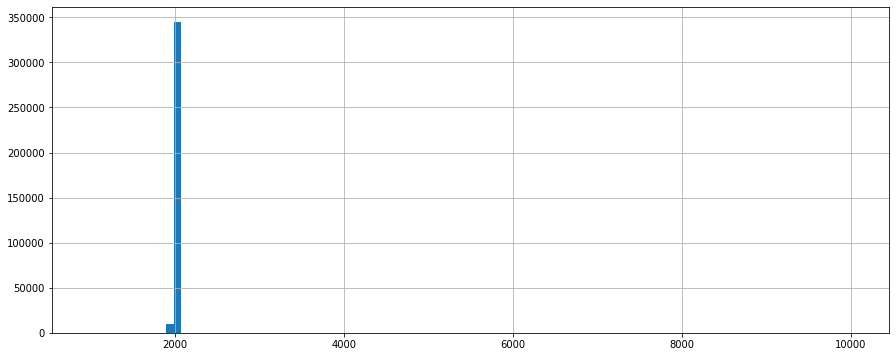

In [23]:
df.registration_year.hist(figsize = (15,6), bins=100);

In [24]:
df = df.loc[(df['registration_year'] <= 2019) & (df['registration_year'] >= 1910)]

In [25]:
np.sort(df.registration_year.unique())

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

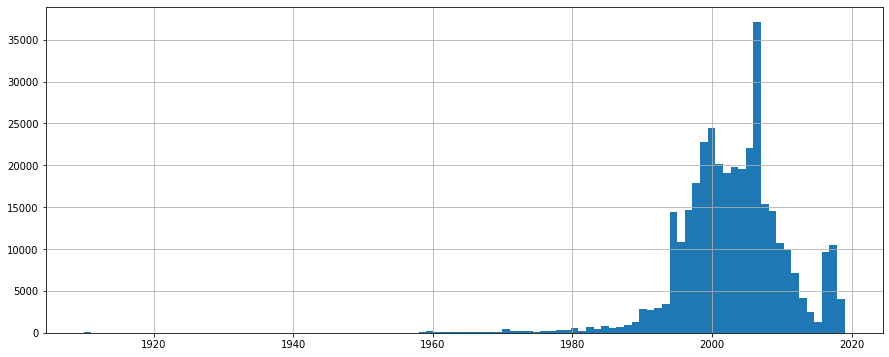

In [26]:
df.registration_year.hist(figsize = (15,6), bins=100);

#### Мощность

In [27]:
# уникальные значения в столбце "мощность"
df.power.value_counts()

0       40098
75      24020
60      15897
150     14590
101     13298
        ...  
9013        1
4400        1
1689        1
1433        1
6006        1
Name: power, Length: 711, dtype: int64

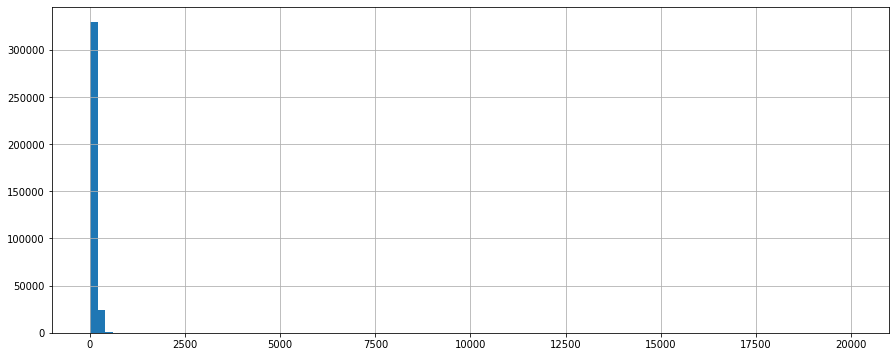

In [28]:
df.power.hist(figsize = (15,6),
             bins=100);

In [29]:
#df.loc[df.power >= 3500, 'power'] = df.power / 100

In [30]:
#df.loc[df.power >= 500, 'power'] = df.power / 10

In [31]:
df.loc[df.power == 0]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,other,2016,unknown,0,kangoo,150000,petrol,renault,no
40,0,other,1990,unknown,0,corsa,150000,petrol,opel,unknown
...,...,...,...,...,...,...,...,...,...,...
354338,180,other,1995,unknown,0,unknown,125000,petrol,opel,unknown
354346,2600,other,2005,auto,0,c_klasse,150000,other,mercedes_benz,unknown
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354364,0,other,2005,manual,0,colt,150000,petrol,mitsubishi,yes


In [32]:
df.loc[df.power > 500]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,unknown,1799,vectra,150000,petrol,opel,yes
3746,0,other,2017,manual,750,unknown,150000,petrol,smart,no
4060,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
...,...,...,...,...,...,...,...,...,...,...
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,petrol,opel,no
353493,12500,other,2017,manual,2000,other,60000,petrol,chrysler,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,unknown


In [33]:
df = df.query('1 <= power < 500')

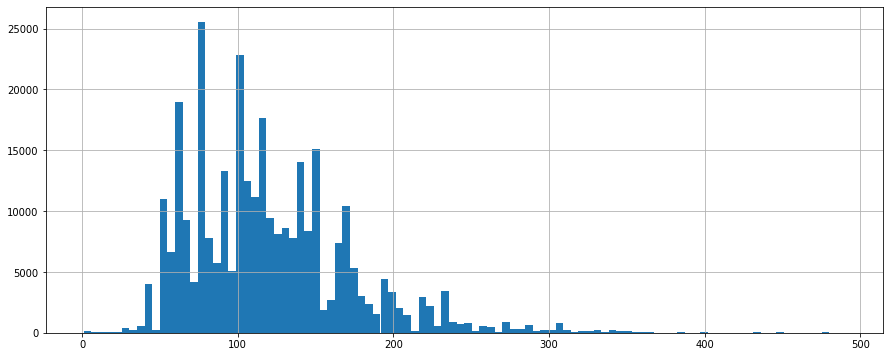

In [34]:
df.power.hist(figsize = (15,6),
             bins=100);

#### Цена

In [35]:
# Удаление строк с нулевым значением цены
df = df.loc[df.price > 0]

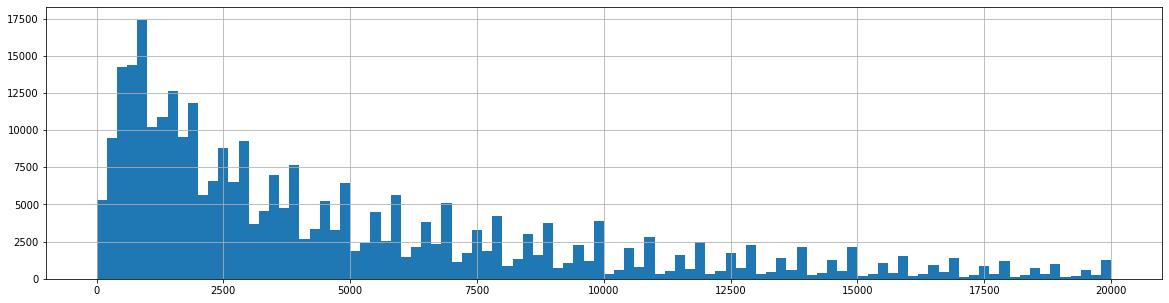

In [36]:
# гистограмма целевого признака:
df.price.hist(bins=100, figsize=(20,5));

In [37]:
# квантили:
df.price.quantile([.025, 0.975])

0.025      290.0
0.975    17000.0
Name: price, dtype: float64

In [38]:
# удаление 2.5% строк, где цена превышает 17000:
df = df.query('price <= 17000')

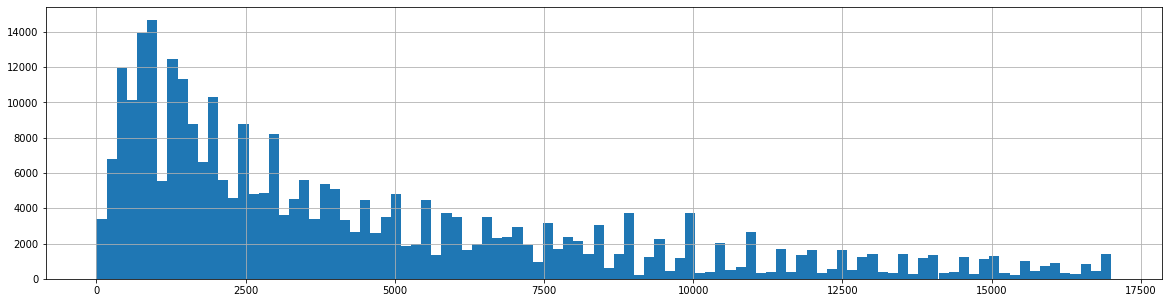

In [39]:
# гистограмма
df.price.hist(bins=100, figsize=(20,5));

#### Пробег

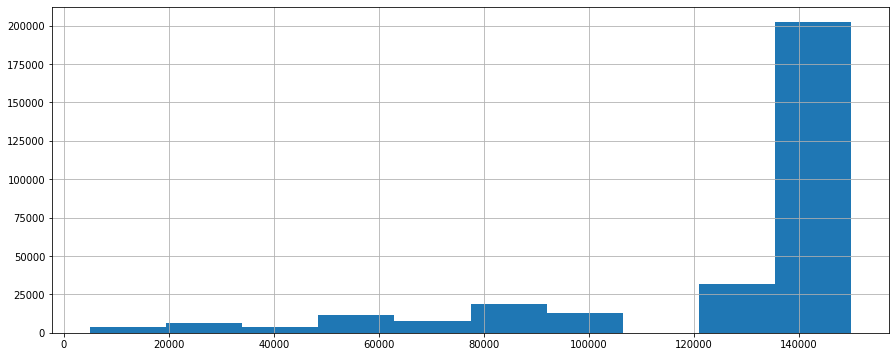

In [40]:
df.kilometer.hist(figsize = (15,6));

In [41]:
df.kilometer.value_counts()

150000    202220
125000     32052
100000     12732
90000      10127
80000       8766
70000       7420
60000       6399
50000       5214
40000       4086
30000       3532
5000        2983
20000       2951
10000        796
Name: kilometer, dtype: int64

В признаке пробег выбросов и аномалий нет.

#### Марка автомобиля

In [42]:
df.brand.value_counts()

volkswagen        65392
opel              33685
bmw               31731
mercedes_benz     26684
audi              25150
ford              21141
renault           14536
peugeot            9605
fiat               7952
seat               6044
skoda              4924
mazda              4834
smart              4605
citroen            4390
nissan             4094
toyota             4056
hyundai            3130
mini               2836
volvo              2799
mitsubishi         2551
honda              2445
kia                2089
alfa_romeo         2015
suzuki             2006
sonstige_autos     1762
chevrolet          1464
chrysler           1183
dacia               822
subaru              644
daihatsu            636
jeep                569
porsche             525
saab                479
land_rover          429
daewoo              428
jaguar              407
lancia              394
rover               386
trabant             297
lada                159
Name: brand, dtype: int64

В признаке марка автомобиля дубликатов нет

In [43]:
df.shape

(299278, 10)

### Вывод:

1. Загружены данные, в данных 354369 строк и 16 признаков:

   * `DateCrawled` — дата скачивания анкеты из базы
   * `VehicleType` — тип автомобильного кузова
   * `RegistrationYear` — год регистрации автомобиля
   * `Gearbox` — тип коробки передач
   * `Power` — мощность (л. с.)
   * `Model` — модель автомобиля
   * `Kilometer` — пробег (км)
   * `RegistrationMonth` — месяц регистрации автомобиля
   * `FuelType` — тип топлива
   * `Brand` — марка автомобиля
   * `Repaired` — была машина в ремонте или нет
   * `DateCreated` — дата создания анкеты
   * `NumberOfPictures` — количество фотографий автомобиля
   * `PostalCode` — почтовый индекс владельца анкеты (пользователя)
   * `LastSeen` — дата последней активности пользователя

    Целевой признак:

       * `Price` — цена (евро)
   
   
   

2. Названия признаков приведены к единому виду.
3. Заполнены пропуски
4. Удалены признаки не влияющие на целевой признак.
5. Удалены дублирующиеся данные.
6. Проведен исследовательский анализ данных:
    1. Признак `Год регистрации` удалены значения с годом меньше 1910 и больше 2019
    2. Признак `Мощность` аномальные приведены значения к нормальным.
    3. Признак `Цена` удалены 5% значений


В результате обработки данных датафрейм сократился на 15.5%, данных (299 278 строк) достаточно для обучения моделей.

## Обучение моделей

In [44]:
df_train = df

In [45]:
df = df_train.sample(frac=0.7,random_state=12345)

In [46]:
val = df_train[~df_train.index.isin(df.index)]

In [47]:
# приведение категориальныч значений признаков к количественным
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.sample(10)

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
200032,13900,2005,190,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
316285,1300,1995,90,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181541,4800,2012,88,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264441,3300,2016,77,70000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
125608,999,1990,75,90000,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
93293,1000,1998,101,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
129796,2000,2002,110,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
209492,17000,2011,156,60000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11610,11900,2012,86,40000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297602,7200,2009,120,10000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# разделение выборки на обучающую и тестовую
X_ohe = df_ohe.drop('price', axis=1)
y_ohe = df_ohe['price']


X_train_ohe, X_test_ohe, \
y_train_ohe, y_test_ohe = train_test_split(X_ohe,
                                   y_ohe,
                                   test_size=0.25,
                                   random_state=12345)


len(X_train_ohe) + len(X_test_ohe) == len(X_ohe)

True

In [49]:
# масштабирование признаков
scaler = StandardScaler()
X_train_ohe = scaler.fit_transform(X_train_ohe)
X_test_ohe = scaler.transform(X_test_ohe)

### Линейная регрессия

In [50]:
lr = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(estimator=lr, param_grid = parameters, cv = 2, n_jobs=-1)
lr_grid = grid.fit(X_train_ohe, y_train_ohe)

In [51]:
f'Оптимальные параметры: {lr_grid.best_params_}'

"Оптимальные параметры: {'copy_X': True, 'fit_intercept': False, 'normalize': True}"

In [52]:
start = time.time()

# обучение модели линейной регрессии
lr = LinearRegression(copy_X=True,
                      fit_intercept=False,
                      normalize=True)
lr.fit(X_train_ohe, y_train_ohe)

time_lr_fit = time.time() - start

display(f'Время обучения модели Линейная регрессия {round(time_lr_fit, 2)} с')

'Время обучения модели Линейная регрессия 23.01 с'

In [53]:
start = time.time()

# предсказание на тестовой выборке
y_pred = lr.predict(X_test_ohe)

time_lr_pred = time.time() - start

display(f'Время предсказания модели Линейная регрессия {round(time_lr_pred, 2)} с')

'Время предсказания модели Линейная регрессия 0.02 с'

In [54]:
rmse_lr = mean_squared_error(y_test_ohe, y_pred)**0.5

display(f'RMSE модели Линейная регрессия: {round(rmse_lr)}')

'RMSE модели Линейная регрессия: 5075'

### LGBMRegressor

In [55]:
X = df.drop('price', axis=1)
y = df['price']

In [56]:
# переведение категориальных признаков к типу category, который требуется для LightGBM
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object':
        X[c] = X[c].astype('category')

In [57]:
#разделение выборки на обучающую и тестовую
X_train, X_test, \
y_train, y_test = train_test_split(X, y,
                                   test_size=0.25,
                                   random_state=12345)

In [58]:
start = time.time()

# обучение модели LGBMRegressor
lgbmr = lgb.LGBMRegressor(random_state=12345)
lgbmr.fit(X_train, y_train)

time_lgbmr_fit = time.time() - start

display(f'Время обучения модели LGBMRegressor {round(time_lgbmr_fit, 2)} с')

'Время обучения модели LGBMRegressor 33.74 с'

In [59]:
start = time.time()

# предсказание на тестовой выборке
y_pred = lgbmr.predict(X_test)

time_lgbmr_pred = time.time() - start

display(f'Время предсказания модели LGBMRegressor {round(time_lgbmr_pred, 2)} с')

'Время предсказания модели LGBMRegressor 0.5 с'

In [60]:
rmse_lgbmr = mean_squared_error(y_test, y_pred)**0.5
display(f'RMSE модели LGBMRegressor: {round(rmse_lgbmr)}')

'RMSE модели LGBMRegressor: 1550'

### CatBoostRegressor

In [61]:
X = df.drop('price', axis=1)
y = df['price']

In [62]:
#разделение выборки на обучающую и тестовую
X_train, X_test, \
y_train, y_test = train_test_split(X, y,
                                   test_size=0.25,
                                   random_state=12345)

In [63]:
cat_features = ['vehicle_type','fuel_type','brand','model', 'gearbox', 'repaired']

In [64]:
parameters = {'depth': [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations': [30, 50, 100]
             }

In [65]:
cbr = CatBoostRegressor(cat_features=cat_features)

In [66]:
cbr_grid = GridSearchCV(estimator=cbr, param_grid = parameters, cv = 2, n_jobs=-1)
cbr_grid.fit(X_train, y_train)

0:	learn: 4051.7698552	total: 87.9ms	remaining: 2.55s
1:	learn: 4026.1341282	total: 123ms	remaining: 1.73s
2:	learn: 4001.9026388	total: 155ms	remaining: 1.39s
3:	learn: 3977.0394908	total: 182ms	remaining: 1.18s
4:	learn: 3953.4329307	total: 219ms	remaining: 1.09s
5:	learn: 3929.8429288	total: 252ms	remaining: 1.01s
6:	learn: 3905.3379145	total: 283ms	remaining: 929ms
7:	learn: 3881.4324750	total: 314ms	remaining: 863ms
8:	learn: 3857.7761087	total: 348ms	remaining: 813ms
9:	learn: 3834.8422651	total: 377ms	remaining: 754ms
10:	learn: 3811.2922324	total: 406ms	remaining: 702ms
11:	learn: 3788.1255486	total: 439ms	remaining: 658ms
12:	learn: 3765.2014278	total: 467ms	remaining: 610ms
13:	learn: 3742.8622802	total: 496ms	remaining: 567ms
14:	learn: 3720.5418671	total: 532ms	remaining: 532ms
15:	learn: 3698.3941718	total: 560ms	remaining: 490ms
16:	learn: 3676.5946651	total: 591ms	remaining: 452ms
17:	learn: 3655.8314239	total: 619ms	remaining: 413ms
18:	learn: 3635.4113532	total: 650ms	

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc00b085550>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [67]:
cbr_grid.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

In [68]:
start = time.time()

cat_features = ['vehicle_type','fuel_type','brand','model', 'gearbox', 'repaired']

# обучение модели CatBoostRegressor
cbr = CatBoostRegressor(learning_rate=.1,
                        iterations=100,
                        depth=10,
                        random_state=12345,
                        verbose=10,
                        cat_features=cat_features)

cbr.fit(X_train, y_train)

time_cbr_fit = time.time() - start

display(f'Время обучения модели CatBoostRegressor {round(time_cbr_fit, 2)} с')

0:	learn: 3798.4681475	total: 114ms	remaining: 11.3s
10:	learn: 2289.8844268	total: 1.07s	remaining: 8.64s
20:	learn: 1850.8605426	total: 1.99s	remaining: 7.48s
30:	learn: 1700.7907831	total: 2.99s	remaining: 6.65s
40:	learn: 1641.1481341	total: 3.96s	remaining: 5.7s
50:	learn: 1605.1205519	total: 4.97s	remaining: 4.77s
60:	learn: 1583.3316484	total: 5.97s	remaining: 3.82s
70:	learn: 1562.0848790	total: 6.94s	remaining: 2.83s
80:	learn: 1546.7856464	total: 7.86s	remaining: 1.84s
90:	learn: 1534.4274792	total: 8.86s	remaining: 876ms
99:	learn: 1523.1315306	total: 9.75s	remaining: 0us


'Время обучения модели CatBoostRegressor 10.59 с'

In [69]:
start = time.time()

# предсказание на тренировочной выборке
y_pred = cbr.predict(X_test)

time_cbr_pred = time.time() - start

display(f'Время предсказания модели CatBoostRegressor {round(time_cbr_pred, 2)} с')

'Время предсказания модели CatBoostRegressor 0.09 с'

In [70]:
rmse_cbr = mean_squared_error(y_test, y_pred) ** .5
display(f'RMSE модели CatBoostRegressor: {round(rmse_cbr)}')

'RMSE модели CatBoostRegressor: 1589'

## Анализ моделей

In [80]:
#создание таблицы по показателям RMSE,
#                                время обучения модели
#                                время предсказания модели
index = ['Линейная регрессия',
         'LGBMRegressor',
         'CatBoostRegressor'
        ]

data = {'RMSE':[round(rmse_lr),
                round(rmse_lgbmr),
                round(rmse_cbr)],

        'Время обучения модели, c':[round(time_lr_fit, 1),
                                    round(time_lgbmr_fit, 1),
                                    round(time_cbr_fit, 1)
                                   ],

        'Время предсказания модели, c':[round(time_lr_pred, 2),
                                        round(time_lgbmr_pred, 2),
                                        round(time_cbr_pred, 2)
                                       ]
       }

kpi = pd.DataFrame(data=data, index=index)

In [81]:
kpi

,RMSE,"Время обучения модели, c","Время предсказания модели, c"
Линейная регрессия,5075,23.0,0.02
LGBMRegressor,1550,33.7,0.50
CatBoostRegressor,1567,10.6,0.09


In [73]:
X = val.drop('price', axis=1)
y = val['price']

In [74]:
y_pred = cbr.predict(X)

In [75]:
rmse_cbr = mean_squared_error(y, y_pred) ** .5
display(f'RMSE модели CatBoostRegressor: {round(rmse_cbr)}')

'RMSE модели CatBoostRegressor: 1567'

### Вывод:
Лучший показатель RMSE у модели LGBMRegressor - `1550`, но у нее худшее время обучения - 34 секунды.
У модели линейной регрессии худший RMSE - `5075`.

Поэтому выбираем модель `CatBoostRegressor` у нее близкий к лучшей модели RMSE - 1567 и лучшее время обучения - 11 секунд.

## Вывод
1. Проведена предобработка данных:
    1. Заполнены пропуски
    2. Удалены дубликаты
2. Проведен исследовательский анализ данных
3. Обучены три модели:
    1. Линейная регрессия
        1. RMSE - 5075;
        2. Время обучения - 23 c; 
        3. Время предсказания модели - 0.02 c.
    2. LGBMRegresso
        1. RMSE - 1550;
        2. Время обучения - 33.7 с;
        3. Время предсказания модели - 0.5 с.
    3. CatBoostRegressor
        1. RMSE - 1567;
        2. Время обучения - 10.6 с; 
        3. Время предсказания модели - 0.09 с.

Выбрана лучшая модель `CatBoostRegressor` и проверена на валидационной выборке.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей